In [12]:
import os
import sys
from wholeslidedata.image.wholeslideimage import WholeSlideImage
from wholeslidedata.annotation.wholeslideannotation import WholeSlideAnnotation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from tqdm.notebook import tqdm
from wholeslidedata.iterators import create_batch_iterator
sys.path.insert(1, os.path.join(sys.path[0], '../..'))
from utils import plot_batch, colors_1
import segmentation_models_pytorch as smp
import argparse
from train_ensemble import Ensemble
from confidence_calibration import avg_entropy_sk_per_patch
from preprocessing import tissue_mask_batch, get_preprocessing
from train_segmentation import load_trained_segmentation_model
from train_ensemble import load_model, Ensemble, SingleModel
from confidence_calibration import avg_entropy_sk, plot_class_probabilities_sample, plot_pred_sample, ece, brier_score, avg_entropy_sk_per_patch

from matplotlib.patches import Circle, Rectangle
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage, AnnotationBbox)

from nn_archs.set_transformer import SetTransformer
from train_slide_classification import SlideGradeModel
from metrics_lib import _validate_probabilities
from skimage.filters import gaussian
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

from sklearn.metrics import cohen_kappa_score, accuracy_score, roc_auc_score, confusion_matrix
from utils import plot_confusion_matrix, plot_roc_curves
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
def entropy_slide(y_pred, epsilon=1e-5):
    """ Computes the entropy per class vs the rest

    Args:
        y_pred: (C, )
        epsilon: small number for computation

    Returns:
        avg_entropy_sk: (C, )
    """
    # validate probabilities
    _validate_probabilities(y_pred)

    num_classes = y_pred.shape[0]
    avg_entropy = np.zeros(num_classes)
    max_entropy = np.log(2) * num_classes

    for c in range(num_classes):
        
        p_c = y_pred[c]
        avg_entropy[c] = -np.sum(p_c * np.log(p_c + epsilon) + (1 - p_c) * np.log(1 - p_c + epsilon))

    return avg_entropy / max_entropy

In [3]:
def entropy_pixel(y_pred, epsilon=1e-5):
    """ Computes the average of pixel-wise entropy values for

    Args:
        y_pred: (N, C)
        epsilon: small number for computation

    Returns:
        avg_entropy_sk: (C, )
    """
    # validate probabilities
    _validate_probabilities(y_pred)
    num_classes = y_pred.shape[1]
    avg_entropy = np.zeros(num_classes)

    for c in range(num_classes):

        # for every pixel the prob of c
        p_c = y_pred[:, c]
        avg_entropy[c] = -(1 / len(p_c)) * np.sum(p_c * np.log(p_c + epsilon) + (1 - p_c) * np.log(1 - p_c + epsilon))

    return avg_entropy

def entropy_pixel_per_patch(y_pred):
    """ Compute the average entropy per patch in a batch

    Args:
        y_pred: (B, C, H, W)

    Returns:
        h: (B, C)
    """
    h = np.zeros((y_pred.shape[0], y_pred.shape[1]))

    for i, y_pred_patch in enumerate(y_pred):
        y_pred_patch = np.transpose(y_pred_patch, (1, 2, 0)).reshape(-1, y_pred.shape[1])
        h[i] = entropy_pixel(y_pred_patch)

    return h

In [4]:
class TileGenerator:
    '''Generates tiles for Numpy images
    '''
    def __init__(self, image, step_size, tile_size):
        
        self.image = image
        self.tile_size = tile_size
        self.step_size = step_size
    
    def get_generator(self):
        img = self.image
        width, height = img.shape[0], img.shape[1]
        x_tiles = int(np.floor(width/self.step_size))
        y_tiles = int(np.floor(height/self.step_size))

        for y in range(y_tiles):
            for x in range(x_tiles):
                x_coord = int(np.round(x*self.step_size))
                y_coord = int(np.round(y*self.step_size))
                tile = img[x_coord: x_coord + self.tile_size, y_coord: y_coord + self.tile_size]
                centre_coord = (x_coord, y_coord)

                # remove when doesnt fit
                if tile.shape == (self.tile_size, self.tile_size, 3):
                    yield tile, centre_coord

In [5]:
# (1) get tiles with overlap
tile_size = 512
step_size = 256
spacing = 1

def tile_generator(imgs, step_size, tile_size):
    '''Generates tiles for Numpy images
    '''
    for img in imgs:
        width, height = img.shape[0], img.shape[1]
        x_tiles = int(np.floor(width/step_size))
        y_tiles = int(np.floor(height/step_size))

        for y in range(y_tiles):
            for x in range(x_tiles):
                x_coord = int(np.round(x*step_size))
                y_coord = int(np.round(y*step_size))
                tile = img[x_coord: x_coord + tile_size, y_coord: y_coord + tile_size]
                centre_coord = (x_coord, y_coord)

                # remove when doesnt fit
                if tile.shape == (tile_size, tile_size, 3):
                    yield tile, centre_coord

In [6]:
# load ensemble of segmentation models
exp_dir = '/data/archief/AMC-data/Barrett/experiments/barrett_gland_grading/3_classes/Ensemble_m5_UNet++_CE_IN/'
preprocessing = get_preprocessing(smp.encoders.get_preprocessing_fn('efficientnet-b4', 'imagenet'))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
ensemble_m5_CE_IN = Ensemble(exp_dir, device=device, m=5)

Loading model: unet++, weights: imagenet
Loaded model from: /data/archief/AMC-data/Barrett/experiments/barrett_gland_grading/3_classes/Ensemble_m5_UNet++_CE_IN/net_0/checkpoints/best_model.pt

Loading model: unet++, weights: imagenet
Loaded model from: /data/archief/AMC-data/Barrett/experiments/barrett_gland_grading/3_classes/Ensemble_m5_UNet++_CE_IN/net_1/checkpoints/best_model.pt

Loading model: unet++, weights: imagenet
Loaded model from: /data/archief/AMC-data/Barrett/experiments/barrett_gland_grading/3_classes/Ensemble_m5_UNet++_CE_IN/net_2/checkpoints/best_model.pt

Loading model: unet++, weights: imagenet
Loaded model from: /data/archief/AMC-data/Barrett/experiments/barrett_gland_grading/3_classes/Ensemble_m5_UNet++_CE_IN/net_3/checkpoints/best_model.pt

Loading model: unet++, weights: imagenet
Loaded model from: /data/archief/AMC-data/Barrett/experiments/barrett_gland_grading/3_classes/Ensemble_m5_UNet++_CE_IN/net_4/checkpoints/best_model.pt



In [8]:
# load slide labbel classification model
#st_weights = '/data/archief/AMC-data/Barrett/experiments/barrett_slide_classification/top_25_entropy/SetTransformer16_top25_bs=512/epoch=245_step=246_val loss=0.52.ckpt'
st_weights = '/data/archief/AMC-data/Barrett/experiments/barrett_slide_classification/entropy_features_wsi/SetTransformer64_wsi_features_top100/epoch=689_step=690_val loss=0.29.ckpt'
model_st = SlideGradeModel(model='st').load_from_checkpoint(st_weights)

|2023-02-03|13:36:07.927| [INFO] Created a temporary directory at /tmp/tmpdioipame
|2023-02-03|13:36:07.929| [INFO] Writing /tmp/tmpdioipame/_remote_module_non_sriptable.py


### **(1) Open an example image**

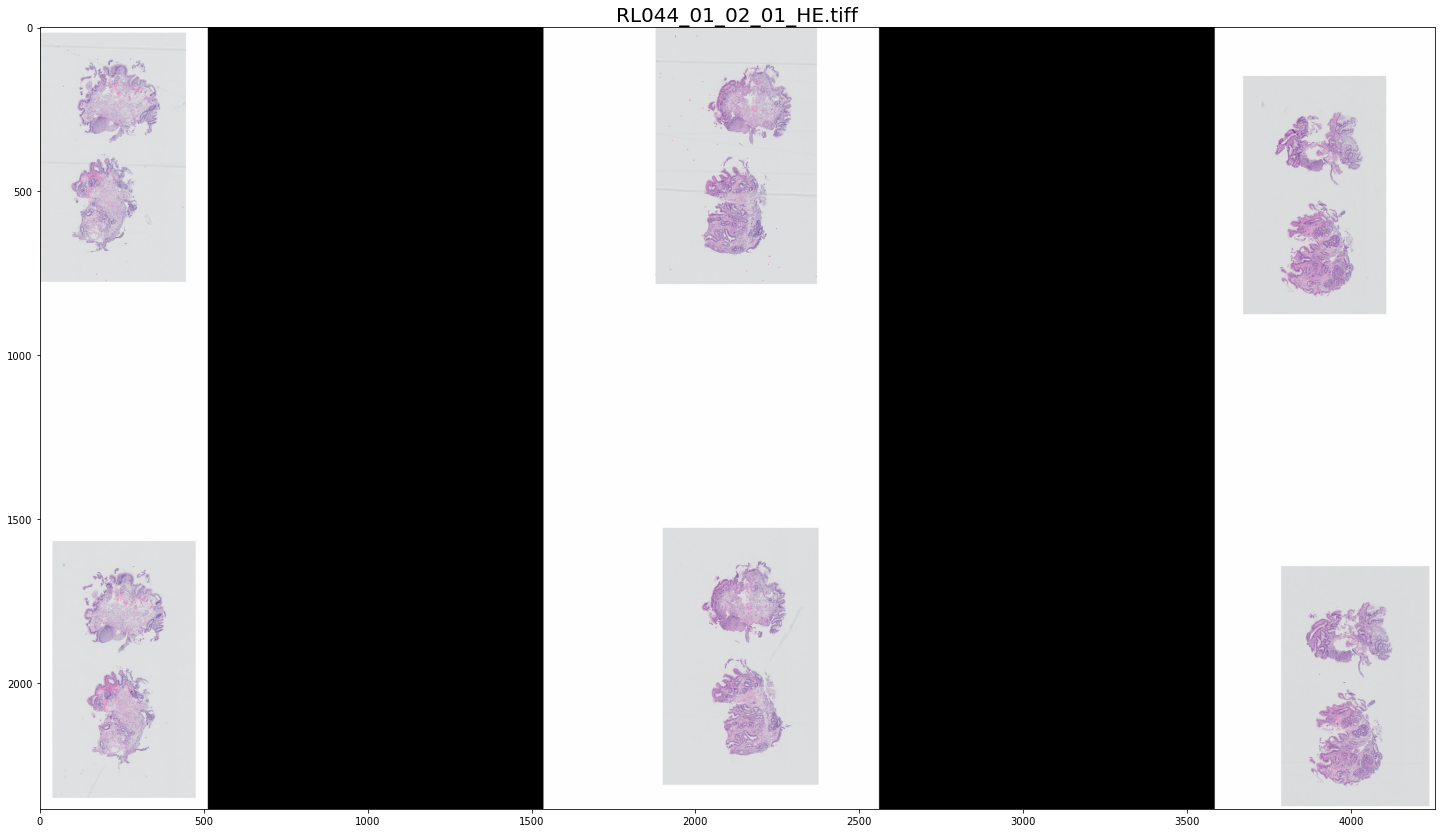

In [9]:
# wsi_path = '/data/archief/AMC-data/Barrett/Bolero/RB0034_HE.tiff'
# wsa_path = '/data/archief/AMC-data/Barrett/Bolero/RB0034_HE.xml'

## UNDERDIAGNOSIS HGD => LGD
# RL044_01_02_01_HE 
# ROCT31_III-HE1
# ROCT38_XI-HE1

## UNCERTAIN between NBDE and LGD
# RBE-00149_HE
# RBET18-04816_HE-V
# RL059_01_03_01_HE

## CLOSE to OVERDIAGNOSIS LGD => HGD
# RBE-00181_HE

example = -5
internal_test_examples = ['ASL/ASL08_1_HE', 'ASL/ASL26_1_HE', 'ASL35_1_HE',
                          'LANS/RL086_01_02_01_HE', 'LANS/RL059_01_03_01_HE', 'LANS/RL185_01_01_01_HE', 'LANS/RL062_01_01_01_HE', 'LANS/RL007_01_02_01_HE', 'LANS/RL044_01_02_01_HE',
                          'RBE/ROCT38_XII-HE1', 'RBE/ROCT38_XI-HE1', 'RBE/ROCT31_III-HE1', 'RBE/RBE-00115_HE']

example_path = internal_test_examples[example]
wsi_path = os.path.join('/data/archief/AMC-data/Barrett/', example_path) + '.tiff'
wsa_path = os.path.join('/data/archief/AMC-data/Barrett/', example_path) + '.xml'

wsa = WholeSlideAnnotation(wsa_path, labels=['biopsy-outlines'])
case_name = wsi_path.split('/')[-1]

# open a WSI
with WholeSlideImage(wsi_path, backend='openslide') as wsi:   
    # extract the whole slide
    slide_spacing=8.0
    slide = wsi.get_slide(spacing=slide_spacing)
    plt.figure(figsize=(25, 15))
    plt.title(case_name, fontsize=20)
    plt.imshow(slide)
    plt.show()

In [10]:
def extract_tiles_2(model, generator, preprocessing, device):
    """ Extracts tiles.

    Args:
            model:
            batch_iterator:
            preprocessing:
            device:

    Returns:
            info_tiles:
    """
    info_tiles = []

    with torch.no_grad():
        for idx, (x_np, loc) in enumerate(tqdm(generator)):
            
            # pre process and put on device
            x = preprocessing(image=np.expand_dims(x_np, axis=0))['image'].to(device)
            y = torch.zeros_like(x)
  
            # forward
            y_hat = model.forward(x, y)

            # naive max grade prediction 
            y_pred_max_grade = np.max(np.argmax(y_hat, axis=1), axis=(1, 2))       # (B, 1)
            avg_msp = np.mean(y_hat, axis=(2, 3))                                  # (B, C)
            
            # entropy (uncertainty score)
            avg_entropy = avg_entropy_sk_per_patch(y_hat)
            avg_entropy_pixel = entropy_pixel_per_patch(y_hat)
            y_hat_nd_vs_d = np.add.reduceat(y_hat, indices=[0, 1, 2], axis=1)
            avg_msp_nd_vs_d = np.mean(y_hat_nd_vs_d, axis=(2, 3))  
            avg_entropy_nd_vs_d = avg_entropy_sk_per_patch(y_hat_nd_vs_d)
                       
            for i in range(len(y_hat)):
                
                # print('Idx: {}, point:  {}, shape: {}: '.format(idx, point, x_np[i].shape))
                info_tiles.append({'loc': loc, 
                                   'naive_pred': y_pred_max_grade[i], 
                                   'avg_msp': avg_msp[i],
                                   'avg_msp_nd_vs_d': avg_msp_nd_vs_d[i],
                                   'avg_msp_pred': avg_msp[i][y_pred_max_grade[i]],
                                   'entropy_pred': avg_entropy[i][y_pred_max_grade[i]], 
                                   'entropy_sk': avg_entropy[i],
                                   'entropy_pixel': avg_entropy_pixel[i],
                                   'entropy_nd_vs_d': avg_entropy_nd_vs_d[i],
                                   'avg_msp_dys': avg_msp_nd_vs_d[i][2],
                                   'entropy_dys': avg_entropy_nd_vs_d[i][2]}) 
                
    return pd.DataFrame(info_tiles)

In [13]:
spacing = 1

with WholeSlideImage(wsi_path, backend='openslide') as wsi:
    slide = wsi.get_slide(spacing=spacing)
    
print('Shape of slide with spacing {}: {}'.format(spacing, slide.shape))

Shape of slide with spacing 1: (19072, 34048, 3)


In [14]:
tile_gn = tile_generator(imgs=[slide], step_size=tile_size, tile_size=tile_size)
info_tiles = extract_tiles_2(model=ensemble_m5_CE_IN, generator=tile_gn, preprocessing=preprocessing, device=device)
#display(info_tiles)

0it [00:00, ?it/s]

In [17]:
# rank on entropy
nr_topsus_tiles = 100
sus_tiles =  info_tiles[info_tiles['naive_pred'] > 1].sort_values(by=['entropy_dys'])[:nr_topsus_tiles]
display(sus_tiles)

,loc,naive_pred,avg_msp,avg_msp_nd_vs_d,avg_msp_pred,entropy_pred,entropy_sk,entropy_pixel,entropy_nd_vs_d,avg_msp_dys,entropy_dys
1267,"(4608, 17408)",3,"[0.74122375, 0.010661939, 0.164162, 0.083952464]","[0.74122375, 0.010661939, 0.24811447]",0.083952,0.733507,"[0.06378878401330709, 1.0, 0.535010339594125, ...","[0.07721909880638123, 0.04692820832133293, 0.1...","[0.06415497621134215, 1.0, 0.22726861160301273]",0.248114,0.227269
2366,"(17920, 32256)",3,"[0.6198635, 0.01582072, 0.22493851, 0.13937722]","[0.6198635, 0.01582072, 0.36431578]",0.139377,0.647278,"[0.07552132007618333, 1.0, 0.5618143485238544,...","[0.10041481256484985, 0.06679925322532654, 0.2...","[0.07458827050673983, 1.0, 0.2578316729979158]",0.364316,0.257832
1327,"(16384, 17920)",3,"[0.9450224, 0.0020895672, 0.02242399, 0.030464...","[0.9450224, 0.0020895672, 0.052888095]",0.030464,0.589844,"[0.01799619610965226, 1.0, 0.6516469866698111,...","[0.02820666879415512, 0.010638444684445858, 0....","[0.01750087616881136, 1.0, 0.29911230672285705]",0.052888,0.299112
2269,"(6144, 31232)",3,"[0.6729499, 0.035686545, 0.21564354, 0.075719975]","[0.6729499, 0.035686545, 0.29136348]",0.075720,0.751416,"[0.0769760193638283, 0.6738555984967625, 0.529...","[0.0990593284368515, 0.09790941327810287, 0.23...","[0.0849985023578167, 0.7970664073620972, 0.322...",0.291363,0.322809
2306,"(6144, 31744)",2,"[0.9249432, 0.0047082515, 0.046156548, 0.02419...","[0.9249432, 0.0047082515, 0.07034852]",0.046157,0.603411,"[0.012881255279077157, 1.0, 0.6034109712763558...","[0.02896660380065441, 0.01890011876821518, 0.0...","[0.013832884082827837, 1.0, 0.3558907630154561]",0.070349,0.355891
...,...,...,...,...,...,...,...,...,...,...,...
2286,"(14848, 31232)",2,"[0.5828942, 0.359382, 0.05196293, 0.0057608085]","[0.5828942, 0.359382, 0.05772373]",0.051963,0.783374,"[0.13319658906501566, 0.32946909395869234, 0.7...","[0.15297120809555054, 0.24837005138397217, 0.1...","[0.1746740237081956, 0.4207312267370414, 0.905...",0.057724,0.905526
121,"(5120, 1536)",2,"[0.9555569, 0.030759443, 0.011643318, 0.002040...","[0.9555569, 0.030759443, 0.0136836935]",0.011643,0.768294,"[0.04043149427857337, 0.6439349879721546, 0.76...","[0.06210189685225487, 0.06249462068080902, 0.0...","[0.05277840716677582, 0.8072176895801729, 0.90...",0.013684,0.909871
2188,"(2560, 30208)",2,"[0.38778502, 0.5470271, 0.06001067, 0.0051771766]","[0.38778502, 0.5470271, 0.06518785]",0.060011,0.789858,"[0.15729500318799633, 0.3034985022422856, 0.78...","[0.15986281633377075, 0.307160884141922, 0.186...","[0.20800673629246016, 0.39151736520989294, 0.9...",0.065188,0.909898
2193,"(5120, 30208)",2,"[0.9347869, 0.05136002, 0.012127707, 0.0017252...","[0.9347869, 0.05136002, 0.01385295]",0.012128,0.790681,"[0.02469679584506981, 0.4373856852492747, 0.79...","[0.035281017422676086, 0.052478522062301636, 0...","[0.03218928275438796, 0.5521466846888942, 0.90...",0.013853,0.909945


### **Whole Slide Level Prediction**
Using tissue from the whole WSI.

In [18]:
# rank on entropy
sus_tiles =  info_tiles[info_tiles['naive_pred'] > 1].sort_values(by=['entropy_pred'])[:nr_topsus_tiles]

if len(sus_tiles) == 0:
    print('Did not find any evidence of dysplasia.')
    sus_tiles = info_tiles[info_tiles['naive_pred'] > 0].sort_values(by=['entropy_pred'])[:nr_topsus_tiles]

# prepare input sequence
x = np.zeros((1, nr_topsus_tiles, 4))

for tile_idx, tile in sus_tiles.reset_index().iterrows():      
    x[0, tile_idx, 0:4] = tile['entropy_sk']    

# make the prediction
classes = ['NDBE', 'LGD', 'HGD'] 
y_logits = model_st.forward(torch.Tensor(x))
y_prob = torch.softmax(y_logits, dim=0).detach().cpu().numpy()
y_pred = np.argmax(y_prob, axis=0)
print('Diagnosis {} with probs NDBE: {:.2f}, LGD: {:.2f}, HGD: {:.2f}'.format(classes[y_pred], y_prob[0], y_prob[1], y_prob[2]))

# class pairwise entropies on pixel level
avg_pixelwise_entropy = tuple(np.round(np.mean(sus_tiles['entropy_sk']), decimals=2))
print('Entropy avg pixel level: {}'.format(avg_pixelwise_entropy))

# slide level class pairwise entropy:
slide_entropy = tuple(np.round(entropy_slide(y_prob), decimals=2))
print('Entropy slide level: {}'.format(slide_entropy))

Diagnosis NDBE with probs NDBE: 0.79, LGD: 0.21, HGD: 0.00
Entropy avg pixel level: (0.08, 0.55, 0.65, 0.97)
Entropy slide level: (0.25, 0.25, 0.0)


### Bolero

In [19]:
# images 
bolero_dir = '/data/archief/AMC-data/Barrett/Bolero/'
bolero_tiffs = sorted([f for f in os.listdir(bolero_dir) if 'tiff' in f])

# labels
bolero_df = pd.read_csv('/data/archief/AMC-data/Barrett/labels/bolero.csv')
bolero_df = bolero_df.rename(columns={'casus nummers': 'case'})
print('Number of WSIs: {}'.format(len(bolero_df)))

# [0, 1, 2, 3] = [NDBE, IND, LGD, HGD]
bolero_df = bolero_df.replace(1, 0)
bolero_df = bolero_df.replace(4, 1)
#display(bolero_df)

Number of WSIs: 55


In [20]:
predictions = []
nr_topsus_tiles = 100

for image in bolero_tiffs:
    
    case = image.split('_')[0]

    # open the image with spacing 1
    with WholeSlideImage(os.path.join(bolero_dir, image), backend='openslide') as wsi:
        slide = wsi.get_slide(spacing=1)

    # tile gen WSI level
    tile_gn = tile_generator(imgs=[slide], step_size=step_size, tile_size=tile_size)
    info_tiles = extract_tiles_2(model=ensemble_m5_CE_IN, generator=tile_gn, preprocessing=preprocessing, device=device)
    
    # rank on entropy
    sus_tiles =  info_tiles[info_tiles['naive_pred'] > 1].sort_values(by=['entropy_pred'])[:nr_topsus_tiles]

    if len(sus_tiles) == 0:
        print('Did not find any evidence of dysplasia.')
        sus_tiles = info_tiles[info_tiles['naive_pred'] > 0].sort_values(by=['entropy_pred'])[:nr_topsus_tiles]

    # prepare input sequence
    x = np.zeros((1, nr_topsus_tiles, 4))

    for tile_idx, tile in sus_tiles.reset_index().iterrows():      
        x[0, tile_idx, 0:4] = tile['entropy_sk']    

    # make the prediction
    y_logits = model_st.forward(torch.Tensor(x))
    y_prob = torch.softmax(y_logits, dim=0).detach().cpu().numpy()
    y_pred = np.argmax(y_prob, axis=0)
    
    print('Case: {}'.format(case))
    classes = ['NDBE', 'LGD', 'HGD']
    print('Diagnosis {} with probs NDBE: {:.2f}, LGD: {:.2f}, HGD: {:.2f}'.format(classes[y_pred], y_prob[0], y_prob[1], y_prob[2]))
    print(' ')
 
    ## UNCERTAINTY
    # class pairwise entropies on pixel level
    avg_pixelwise_entropy = tuple(np.round(np.mean(sus_tiles['entropy_pixel']), decimals=2))
    print('Entropy avg pixel level: {}'.format(avg_pixelwise_entropy))

    # Slide level class pairwise entropy:
    slide_entropy = tuple(np.round(entropy_slide(y_prob), decimals=2))
    print('Entropy slide level: {}'.format(slide_entropy))
    
    predictions.append({'case': case, 'pred': y_pred, 'p_ndbe': y_prob[0], 'p_lgd': y_prob[1], 'p_hgd': y_prob[2],
                        'entropy_slide_level': slide_entropy, 'entropy_avg_pixel_level': avg_pixelwise_entropy})

0it [00:00, ?it/s]

Case: RB0001
Diagnosis LGD with probs NDBE: 0.01, LGD: 0.90, HGD: 0.09
 
Entropy avg pixel level: (0.13, 0.14, 0.28, 0.17)
Entropy slide level: (0.02, 0.16, 0.15)


0it [00:00, ?it/s]

Case: RB0002
Diagnosis HGD with probs NDBE: 0.00, LGD: 0.00, HGD: 1.00
 
Entropy avg pixel level: (0.12, 0.04, 0.15, 0.2)
Entropy slide level: (0.0, 0.0, 0.0)


0it [00:00, ?it/s]

Case: RB0003
Diagnosis NDBE with probs NDBE: 0.56, LGD: 0.44, HGD: 0.00
 
Entropy avg pixel level: (0.07, 0.12, 0.1, 0.03)
Entropy slide level: (0.33, 0.33, 0.0)


0it [00:00, ?it/s]

Case: RB0004
Diagnosis LGD with probs NDBE: 0.03, LGD: 0.96, HGD: 0.01
 
Entropy avg pixel level: (0.13, 0.14, 0.23, 0.13)
Entropy slide level: (0.06, 0.08, 0.03)


0it [00:00, ?it/s]

Case: RB0005
Diagnosis LGD with probs NDBE: 0.16, LGD: 0.84, HGD: 0.00
 
Entropy avg pixel level: (0.12, 0.21, 0.2, 0.06)
Entropy slide level: (0.21, 0.21, 0.0)


0it [00:00, ?it/s]

Case: RB0006
Diagnosis LGD with probs NDBE: 0.28, LGD: 0.72, HGD: 0.00
 
Entropy avg pixel level: (0.2, 0.25, 0.23, 0.09)
Entropy slide level: (0.29, 0.29, 0.0)


0it [00:00, ?it/s]

Case: RB0007
Diagnosis LGD with probs NDBE: 0.13, LGD: 0.87, HGD: 0.00
 
Entropy avg pixel level: (0.13, 0.22, 0.25, 0.11)
Entropy slide level: (0.18, 0.18, 0.0)


0it [00:00, ?it/s]

Case: RB0008
Diagnosis LGD with probs NDBE: 0.07, LGD: 0.93, HGD: 0.00
 
Entropy avg pixel level: (0.11, 0.19, 0.23, 0.09)
Entropy slide level: (0.12, 0.12, 0.0)


0it [00:00, ?it/s]

Case: RB0009
Diagnosis HGD with probs NDBE: 0.00, LGD: 0.00, HGD: 1.00
 
Entropy avg pixel level: (0.17, 0.05, 0.17, 0.26)
Entropy slide level: (0.0, 0.0, 0.0)


0it [00:00, ?it/s]

Case: RB0010
Diagnosis LGD with probs NDBE: 0.07, LGD: 0.93, HGD: 0.00
 
Entropy avg pixel level: (0.11, 0.17, 0.21, 0.1)
Entropy slide level: (0.12, 0.13, 0.01)


0it [00:00, ?it/s]

Case: RB0011
Diagnosis LGD with probs NDBE: 0.28, LGD: 0.72, HGD: 0.00
 
Entropy avg pixel level: (0.13, 0.21, 0.16, 0.05)
Entropy slide level: (0.28, 0.28, 0.0)


0it [00:00, ?it/s]

Case: RB0012
Diagnosis LGD with probs NDBE: 0.07, LGD: 0.92, HGD: 0.01
 
Entropy avg pixel level: (0.11, 0.11, 0.16, 0.08)
Entropy slide level: (0.13, 0.14, 0.02)


0it [00:00, ?it/s]

Case: RB0013
Diagnosis LGD with probs NDBE: 0.29, LGD: 0.71, HGD: 0.00
 
Entropy avg pixel level: (0.09, 0.13, 0.13, 0.06)
Entropy slide level: (0.29, 0.29, 0.0)


0it [00:00, ?it/s]

Case: RB0014
Diagnosis LGD with probs NDBE: 0.18, LGD: 0.82, HGD: 0.01
 
Entropy avg pixel level: (0.13, 0.2, 0.28, 0.15)
Entropy slide level: (0.23, 0.23, 0.02)


0it [00:00, ?it/s]

Case: RB0015
Diagnosis NDBE with probs NDBE: 0.81, LGD: 0.19, HGD: 0.00
 
Entropy avg pixel level: (0.11, 0.18, 0.14, 0.04)
Entropy slide level: (0.24, 0.24, 0.0)


0it [00:00, ?it/s]

Case: RB0016
Diagnosis HGD with probs NDBE: 0.01, LGD: 0.23, HGD: 0.76
 
Entropy avg pixel level: (0.1, 0.11, 0.15, 0.11)
Entropy slide level: (0.03, 0.26, 0.27)


0it [00:00, ?it/s]

Case: RB0017
Diagnosis LGD with probs NDBE: 0.04, LGD: 0.96, HGD: 0.01
 
Entropy avg pixel level: (0.12, 0.18, 0.23, 0.1)
Entropy slide level: (0.08, 0.09, 0.02)


0it [00:00, ?it/s]

Case: RB0018
Diagnosis LGD with probs NDBE: 0.01, LGD: 0.86, HGD: 0.13
 
Entropy avg pixel level: (0.1, 0.08, 0.16, 0.1)
Entropy slide level: (0.03, 0.2, 0.19)


0it [00:00, ?it/s]

Case: RB0019
Diagnosis LGD with probs NDBE: 0.49, LGD: 0.51, HGD: 0.00
 
Entropy avg pixel level: (0.09, 0.18, 0.14, 0.05)
Entropy slide level: (0.33, 0.33, 0.0)


0it [00:00, ?it/s]

Case: RB0020
Diagnosis NDBE with probs NDBE: 1.00, LGD: 0.00, HGD: 0.00
 
Entropy avg pixel level: (0.08, 0.16, 0.12, 0.03)
Entropy slide level: (0.01, 0.01, 0.0)


0it [00:00, ?it/s]

Case: RB0021
Diagnosis LGD with probs NDBE: 0.01, LGD: 0.80, HGD: 0.19
 
Entropy avg pixel level: (0.12, 0.1, 0.21, 0.15)
Entropy slide level: (0.03, 0.24, 0.23)


0it [00:00, ?it/s]

Case: RB0022
Diagnosis LGD with probs NDBE: 0.19, LGD: 0.81, HGD: 0.00
 
Entropy avg pixel level: (0.11, 0.14, 0.16, 0.07)
Entropy slide level: (0.23, 0.23, 0.0)


0it [00:00, ?it/s]

Case: RB0023
Diagnosis LGD with probs NDBE: 0.06, LGD: 0.94, HGD: 0.00
 
Entropy avg pixel level: (0.12, 0.2, 0.21, 0.1)
Entropy slide level: (0.11, 0.11, 0.0)


0it [00:00, ?it/s]

Case: RB0024
Diagnosis NDBE with probs NDBE: 0.99, LGD: 0.01, HGD: 0.00
 
Entropy avg pixel level: (0.09, 0.1, 0.06, 0.03)
Entropy slide level: (0.02, 0.02, 0.0)


0it [00:00, ?it/s]

Case: RB0025
Diagnosis LGD with probs NDBE: 0.02, LGD: 0.96, HGD: 0.01
 
Entropy avg pixel level: (0.14, 0.13, 0.25, 0.15)
Entropy slide level: (0.05, 0.07, 0.03)


0it [00:00, ?it/s]

Case: RB0026
Diagnosis HGD with probs NDBE: 0.00, LGD: 0.00, HGD: 1.00
 
Entropy avg pixel level: (0.13, 0.05, 0.18, 0.23)
Entropy slide level: (0.0, 0.0, 0.0)


0it [00:00, ?it/s]

Case: RB0027
Diagnosis LGD with probs NDBE: 0.20, LGD: 0.80, HGD: 0.00
 
Entropy avg pixel level: (0.12, 0.18, 0.19, 0.07)
Entropy slide level: (0.24, 0.24, 0.0)


0it [00:00, ?it/s]

Case: RB0028
Diagnosis LGD with probs NDBE: 0.07, LGD: 0.93, HGD: 0.00
 
Entropy avg pixel level: (0.15, 0.2, 0.3, 0.16)
Entropy slide level: (0.12, 0.13, 0.0)


0it [00:00, ?it/s]

Case: RB0029
Diagnosis LGD with probs NDBE: 0.08, LGD: 0.92, HGD: 0.00
 
Entropy avg pixel level: (0.13, 0.19, 0.25, 0.1)
Entropy slide level: (0.13, 0.14, 0.01)


0it [00:00, ?it/s]

Case: RB0030
Diagnosis NDBE with probs NDBE: 0.93, LGD: 0.02, HGD: 0.05
 
Entropy avg pixel level: (0.05, 0.05, 0.03, 0.02)
Entropy slide level: (0.12, 0.04, 0.1)


0it [00:00, ?it/s]

Case: RB0031
Diagnosis LGD with probs NDBE: 0.09, LGD: 0.91, HGD: 0.00
 
Entropy avg pixel level: (0.12, 0.24, 0.2, 0.05)
Entropy slide level: (0.15, 0.15, -0.0)


0it [00:00, ?it/s]

Case: RB0032
Diagnosis NDBE with probs NDBE: 0.94, LGD: 0.02, HGD: 0.05
 
Entropy avg pixel level: (0.1, 0.08, 0.06, 0.03)
Entropy slide level: (0.11, 0.04, 0.09)


0it [00:00, ?it/s]

Case: RB0033
Diagnosis LGD with probs NDBE: 0.33, LGD: 0.67, HGD: 0.00
 
Entropy avg pixel level: (0.13, 0.24, 0.2, 0.06)
Entropy slide level: (0.31, 0.31, -0.0)


0it [00:00, ?it/s]

Case: RB0034
Diagnosis HGD with probs NDBE: 0.06, LGD: 0.30, HGD: 0.64
 
Entropy avg pixel level: (0.11, 0.15, 0.18, 0.12)
Entropy slide level: (0.11, 0.29, 0.31)


0it [00:00, ?it/s]

Case: RB0035
Diagnosis LGD with probs NDBE: 0.04, LGD: 0.81, HGD: 0.16
 
Entropy avg pixel level: (0.15, 0.12, 0.23, 0.17)
Entropy slide level: (0.07, 0.23, 0.21)


0it [00:00, ?it/s]

Case: RB0036
Diagnosis LGD with probs NDBE: 0.21, LGD: 0.79, HGD: 0.00
 
Entropy avg pixel level: (0.15, 0.3, 0.27, 0.08)
Entropy slide level: (0.25, 0.25, -0.0)


0it [00:00, ?it/s]

Case: RB0037
Diagnosis LGD with probs NDBE: 0.41, LGD: 0.59, HGD: 0.00
 
Entropy avg pixel level: (0.12, 0.25, 0.27, 0.12)
Entropy slide level: (0.33, 0.33, 0.0)


0it [00:00, ?it/s]

Case: RB0038
Diagnosis LGD with probs NDBE: 0.15, LGD: 0.85, HGD: 0.00
 
Entropy avg pixel level: (0.13, 0.26, 0.22, 0.07)
Entropy slide level: (0.21, 0.21, -0.0)


0it [00:00, ?it/s]

Case: RB0039
Diagnosis LGD with probs NDBE: 0.28, LGD: 0.71, HGD: 0.01
 
Entropy avg pixel level: (0.12, 0.19, 0.21, 0.11)
Entropy slide level: (0.28, 0.29, 0.02)


0it [00:00, ?it/s]

Case: RB0040
Diagnosis LGD with probs NDBE: 0.07, LGD: 0.93, HGD: 0.00
 
Entropy avg pixel level: (0.12, 0.24, 0.25, 0.09)
Entropy slide level: (0.12, 0.12, 0.0)


0it [00:00, ?it/s]

Case: RB0041
Diagnosis HGD with probs NDBE: 0.03, LGD: 0.41, HGD: 0.56
 
Entropy avg pixel level: (0.16, 0.15, 0.26, 0.22)
Entropy slide level: (0.07, 0.33, 0.33)


0it [00:00, ?it/s]

Case: RB0042
Diagnosis LGD with probs NDBE: 0.50, LGD: 0.50, HGD: 0.00
 
Entropy avg pixel level: (0.09, 0.15, 0.11, 0.04)
Entropy slide level: (0.33, 0.33, 0.0)


0it [00:00, ?it/s]

Case: RB0043
Diagnosis NDBE with probs NDBE: 0.98, LGD: 0.02, HGD: 0.00
 
Entropy avg pixel level: (0.06, 0.12, 0.1, 0.03)
Entropy slide level: (0.05, 0.05, 0.0)


0it [00:00, ?it/s]

Case: RB0044
Diagnosis LGD with probs NDBE: 0.15, LGD: 0.85, HGD: 0.00
 
Entropy avg pixel level: (0.13, 0.19, 0.22, 0.09)
Entropy slide level: (0.2, 0.2, 0.0)


0it [00:00, ?it/s]

Case: RB0045
Diagnosis LGD with probs NDBE: 0.05, LGD: 0.95, HGD: 0.00
 
Entropy avg pixel level: (0.14, 0.19, 0.24, 0.11)
Entropy slide level: (0.1, 0.1, 0.0)


0it [00:00, ?it/s]

Case: RB0046
Diagnosis LGD with probs NDBE: 0.15, LGD: 0.84, HGD: 0.01
 
Entropy avg pixel level: (0.11, 0.14, 0.17, 0.1)
Entropy slide level: (0.21, 0.21, 0.02)


0it [00:00, ?it/s]

Case: RB0047
Diagnosis LGD with probs NDBE: 0.34, LGD: 0.66, HGD: 0.00
 
Entropy avg pixel level: (0.12, 0.19, 0.24, 0.14)
Entropy slide level: (0.31, 0.31, 0.0)


0it [00:00, ?it/s]

Case: RB0048
Diagnosis HGD with probs NDBE: 0.00, LGD: 0.00, HGD: 1.00
 
Entropy avg pixel level: (0.15, 0.05, 0.18, 0.24)
Entropy slide level: (0.0, 0.01, 0.01)


0it [00:00, ?it/s]

Case: RB0049
Diagnosis LGD with probs NDBE: 0.36, LGD: 0.64, HGD: 0.00
 
Entropy avg pixel level: (0.12, 0.16, 0.18, 0.09)
Entropy slide level: (0.32, 0.32, 0.0)


0it [00:00, ?it/s]

Case: RB0050
Diagnosis LGD with probs NDBE: 0.19, LGD: 0.81, HGD: 0.00
 
Entropy avg pixel level: (0.12, 0.26, 0.24, 0.06)
Entropy slide level: (0.23, 0.23, 0.0)


0it [00:00, ?it/s]

Case: RB0051
Diagnosis LGD with probs NDBE: 0.13, LGD: 0.87, HGD: 0.00
 
Entropy avg pixel level: (0.15, 0.18, 0.26, 0.13)
Entropy slide level: (0.18, 0.18, 0.0)


0it [00:00, ?it/s]

Case: RB0052
Diagnosis HGD with probs NDBE: 0.00, LGD: 0.00, HGD: 1.00
 
Entropy avg pixel level: (0.2, 0.06, 0.27, 0.37)
Entropy slide level: (0.0, 0.0, 0.0)


0it [00:00, ?it/s]

Case: RB0053
Diagnosis LGD with probs NDBE: 0.01, LGD: 0.99, HGD: 0.00
 
Entropy avg pixel level: (0.17, 0.19, 0.31, 0.15)
Entropy slide level: (0.03, 0.04, 0.0)


0it [00:00, ?it/s]

Case: RB0054
Diagnosis LGD with probs NDBE: 0.23, LGD: 0.77, HGD: 0.00
 
Entropy avg pixel level: (0.13, 0.3, 0.28, 0.09)
Entropy slide level: (0.26, 0.26, 0.0)


0it [00:00, ?it/s]

Case: RB0055
Diagnosis NDBE with probs NDBE: 0.94, LGD: 0.01, HGD: 0.04
 
Entropy avg pixel level: (0.12, 0.07, 0.05, 0.03)
Entropy slide level: (0.1, 0.03, 0.08)


In [21]:
# with IND => we never predict ind
predictions_df = pd.DataFrame(predictions)
#predictions_df.to_csv('/data/archief/AMC-data/Barrett/labels/predictions_df_wsi.csv', index=False)
predictions_df = predictions_df.replace(2, 3)
predictions_df = predictions_df.replace(1, 2)

result_df = predictions_df.merge(bolero_df, on='case')
print(len(result_df))

55


In [22]:
def plot_confusion_matrix_ind(cf_matrix, save_path=None, pixel_level=True, kappa=None, acc=None, y_label='True', x_label='Pred'):
    labels = ['NDBE', 'IND', 'LGD', 'HGD']
    fmt = 'd'

    df_cm = pd.DataFrame(cf_matrix, index=labels, columns=labels)

    plt.figure(figsize=(15, 10))
    plt.rcParams.update({'font.size': 22})
    sns.heatmap(df_cm, annot=True, cmap="Blues", square=True, fmt=fmt)
    plt.gca().set_yticklabels(labels=labels, va='center')
    plt.gca().set_ylabel(y_label, labelpad=30)
    plt.gca().set_xlabel(x_label, labelpad=30)
    plt.title('$\kappa=${:.2f}, acc={:.2f}'.format(kappa, acc))
    plt.show()

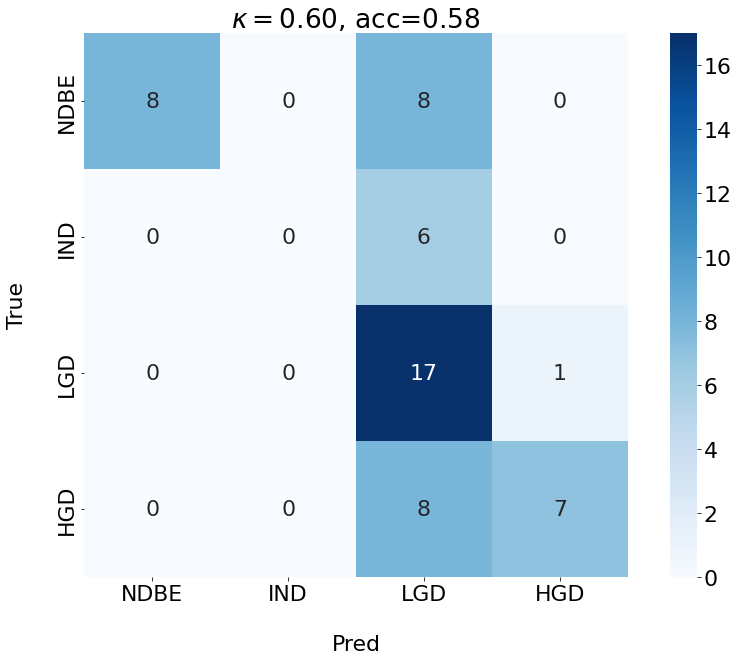

In [23]:
# compute metrics
y_true = result_df['gold standard diagnosis']
y_pred = result_df['pred']
y_prob = result_df[['p_ndbe', 'p_lgd', 'p_hgd']]

acc = accuracy_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred, weights='quadratic')
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3])
plot_confusion_matrix_ind(cm, kappa=kappa, acc=acc)

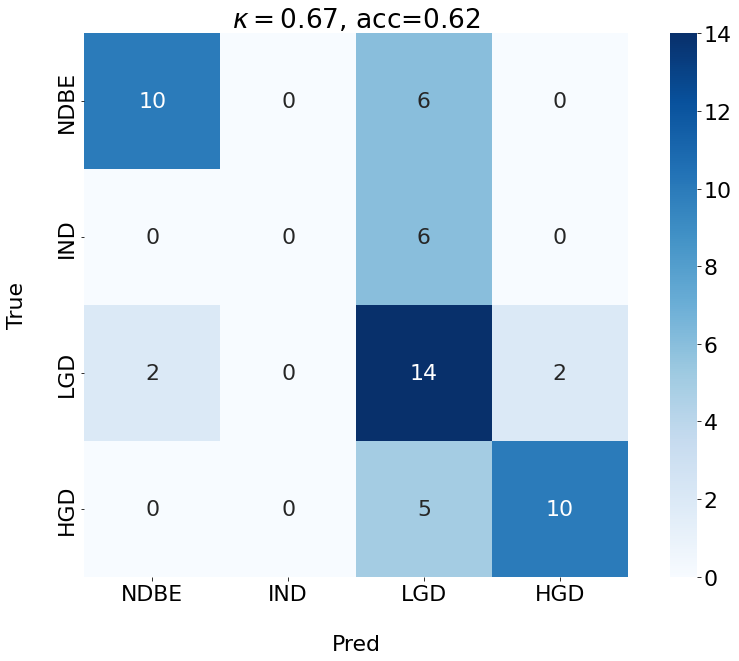

In [ ]:
# Results: SetTransformer model trained with features from biopsy outlines only